![dsl logo](https://github.com/BrockDSL/ARCH_Data_Explore/blob/main/dsl_logo.png?raw=true)

# Calculated and displayed is the number of weeks where vaccines were mentioned by each municipality in 2021. 

In [ ]:
import pandas as pd
import requests
import pprint
import re
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('max_colwidth', 400)

In [ ]:
def download_file(url, filename=None, loud=True):
  
  if not filename:
    filename = url.split('/')[-1]
  
  r = requests.get(url, stream=True)
  if loud:
    total_bytes_dl = 0
    content_len = int(r.headers['Content-Length'])

  with open(filename, 'wb') as fd:
      for chunk in r.iter_content(chunk_size=4096):
          fd.write(chunk)
          if loud:
            total_bytes_dl += 4096
            percent = int((total_bytes_dl / content_len) * 100.0)
            print(f'\rDownload progress of {filename} {total_bytes_dl}/{content_len}: {percent}%',end='')
  r.close()

def get_muni_data():
  download_file("https://brockau.s3.us-east-2.amazonaws.com/url_cv19.csv.gz")
  !gunzip -f url_cv19.csv.gz
  archive_data = pd.read_csv("url_cv19.csv")
  archive_data.crawl_date = pd.to_datetime(archive_data.crawl_date)
  archive_data.content = archive_data.content.astype("string")
  return archive_data

r = requests.get('https://raw.githubusercontent.com/BrockDSL/ARCH_Data_Explore/main/urls_of_interest.txt')
urls_of_interest = r.text.split()

domains = [
"westlincoln.ca",
"thorold.ca",
"forterie.ca",
"welland.ca",
"niagararegion.ca",
"notl.com",
"wainfleet.ca",
"portcolborne.ca",
"grimsby.ca",
"lincoln.ca",
"pelham.ca",
"niagarafalls.ca",
"stcatharines.ca"]

#Retrieve data 
data = get_muni_data()
#data = data[data.content.notna()]
data = data[data.url.isin(urls_of_interest)].drop_duplicates(subset=['crawl_date','url','content'])
data = data.sort_values(by=['domain', 'crawl_date'])
data = data.set_index('domain')

Download progress of url_cv19.csv.gz 4116480/4116015: 100%

In [ ]:
domain_data = []
for d in domains:
  domain = data[data.crawl_date >= '2021-01-01'].loc[d]

  #Create a 365 day range that we can index our data onto
  year_range = pd.DataFrame(index=pd.date_range("2021-01-01", periods=365, freq="d"))
  
  for url in set(domain.url):
    url_data = domain.loc[domain.url == url].sort_values(by=['crawl_date'])

    #NA rows are crawls that have duplicate content compared to the previous crawl
    #use ffill to denote whether a duplicate row contains our keyword
    #use bfill to fill in NA values that denote duplicate content from crawls before 2021
    url_mask = url_data.content.str.contains('vaccine|vaccinated|vaccination', flags=re.IGNORECASE).fillna(method='ffill').fillna(method='bfill')
    
    #retrieve all dates with vaccine content (this includes NA rows that we have noted as having duplicate content as previous vaccine content crawls)
    #drop duplicate rows on the with the same date (many duplicate content crawls are done on the same day)
    url_data = url_data[url_mask].sort_values(['url','crawl_date','content']).drop_duplicates(subset=['crawl_date', 'url'])
    
    url_data.index = url_data.crawl_date
    url_data = url_data.drop(['crawl_date','content'], axis=1).rename(columns={'url':url})
    year_range = year_range.join(url_data, how='outer')
  
  #A special case is necessary for st.catharines which is missing december data 
  #It was manually verified via the wayback machine that the mentions exist
  if d == 'stcatharines.ca':
    year_range.loc[['2021-12-03','2021-12-10','2021-12-17','2021-12-24','2021-12-31'],'url'] = 'https://www.stcatharines.ca/en/livein/covid-19.asp'

  #Resample down to a weekly range ('W-FRI' makes the range start on 2021-01-01 which was a monday)  
  domain_totals = year_range.resample('W-FRI').count().any(axis='columns')
  domain_totals.name = d
  domain_data.append(domain_totals)
final_result = pd.concat(domain_data, axis=1)

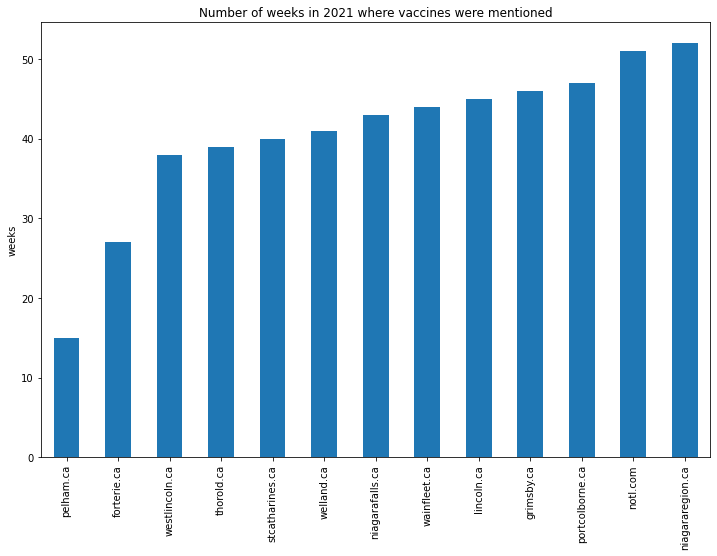

In [ ]:
final_result.sum().sort_values().plot.bar(title="Number of weeks in 2021 where vaccines were mentioned", ylabel="weeks", figsize=(12,8))